Reference: [Corrective RAG (CRAG)](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_crag/)

In [1]:
#%pip install -U langchain-ollama

In [2]:
import os
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [3]:
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY:  ········


In [4]:
_set_env("ANYPOINT_CLIENT_ID")
_set_env("ANYPOINT_CLIENT_SECRET")

ANYPOINT_CLIENT_ID:  ········
ANYPOINT_CLIENT_SECRET:  ········


In [5]:
from langchain_ollama import ChatOllama

LLAMA_API_ENDPOINT="https://api.ollama.ai:30461/ollama"
headers = {
    "Client_ID": os.environ.get("ANYPOINT_CLIENT_ID"),
    "Client_Secret": os.environ.get("ANYPOINT_CLIENT_SECRET")
}

# Test
llm = ChatOllama(
    model = "llama3.1",
    temperature = 0,
    base_url = LLAMA_API_ENDPOINT,
    client_kwargs={"headers": headers}
)

messages = [
    ("system", "You are a helpful assistant"),
    ("human", "tell me a joke."),
]
print(llm.invoke(messages).content)

Here's one:

What do you call a fake noodle?

An impasta!

Hope that made you smile! Do you want to hear another one?


In [6]:
# /// Retriever tool ///
import chromadb

from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Embedding model name
EMBEDDING_MODEL_NAME = "hkunlp/instructor-large"

# Define the Chroma settings
CHROMA_SETTINGS = chromadb.config.Settings(
    anonymized_telemetry=False,
    is_persistent=False,
)

embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL_NAME)
chroma_client = chromadb.Client(settings=CHROMA_SETTINGS)

urls = [
    "https://blogs.mulesoft.com/digital-transformation/owasp-top-10-playbook/",
    "https://blogs.mulesoft.com/news/einstein-for-anypoint-code-builder/",
    "https://blogs.mulesoft.com/news/transition-from-persistent-vm-queues-to-robust-message-brokers/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    client=chroma_client,
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)
retriever = vectorstore.as_retriever(k=2)

USER_AGENT environment variable not set, consider setting it to identify your requests.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [7]:
from langchain_ollama import ChatOllama
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    
    Use the following documents to answer the question. 
    
    If you don't know the answer, just say that you don't know. 
    
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Documents: {documents} 
    Answer: 
    """,
    input_variables=["question", "documents"],
)

llm = ChatOllama(
    model = "llama3.1",
    temperature = 0,
    base_url = LLAMA_API_ENDPOINT,
    client_kwargs={"headers": headers}
)

rag_chain = prompt | llm | StrOutputParser()

In [8]:
# /// Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.schema import Document

web_search_tool = TavilySearchResults()

In [9]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser

# JSON
llm = ChatOllama(
    model = "llama3.1",
    temperature = 0,
    format="json",
    base_url = LLAMA_API_ENDPOINT,
    client_kwargs={"headers": headers}
)


prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.""",
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()

In [10]:
from typing_extensions import TypedDict, List
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    question = state["question"]
    documents = retriever.invoke(question)
    steps = state["steps"]
    steps.append("retrieve_documents")
    return {"documents": documents, "question": question, "steps": steps}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            filtered_docs.append(d)
        else:
            search = "Yes"
            continue
    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    web_results = web_search_tool.invoke({"query": question})
    documents.extend(
        [
            Document(page_content=d["content"], metadata={"url": d["url"]})
            for d in web_results
        ]
    )
    return {"documents": documents, "question": question, "steps": steps}


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    search = state["search"]
    if search == "Yes":
        return "search"
    else:
        return "generate"


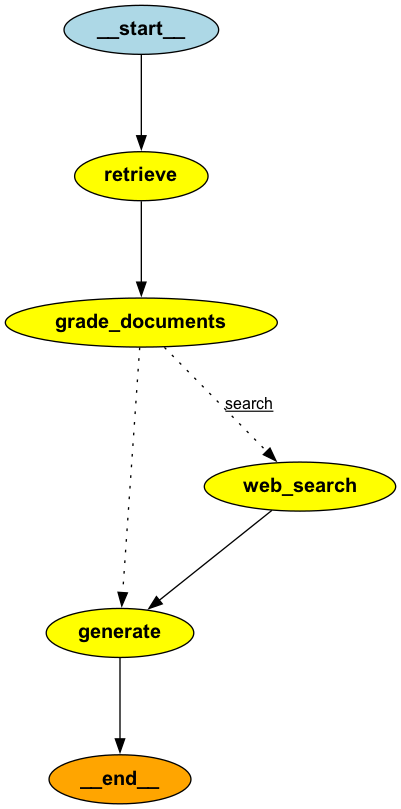

In [11]:
# Graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "search": "web_search",
        "generate": "generate",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

custom_graph = workflow.compile()


display(Image(custom_graph.get_graph(xray=True).draw_png()))

In [12]:
import uuid


def predict_custom_agent_answer(example: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}

    state_dict = custom_graph.invoke(
        {"question": example["input"], "steps": []}, config
    )

    #return {"response": state_dict["generation"], "steps": state_dict["steps"]}
    return state_dict


example = {"input": "What's new with the release of Einstein for Anypoint Code Builder"}
response = predict_custom_agent_answer(example)
response

{'question': "What's new with the release of Einstein for Anypoint Code Builder",
 'generation': "Einstein for Anypoint Code Builder is now available in General Availability (GA), allowing developers to use natural language processing to generate integration flows and simplify configuration processes. This release represents a significant leap forward in integration development, combining the power of AI with MuleSoft's reliability and security. Developers can get started by signing into their Anypoint Platform account or signing up for a free trial account.",
 'search': 'No',
 'documents': [Document(metadata={'description': "Discover Einstein for Anypoint Code Builder GA – developers and IT decision-makers, you do not want to miss out on MuleSoft's new GA release of AI on ACB!", 'language': 'en-US', 'source': 'https://blogs.mulesoft.com/news/einstein-for-anypoint-code-builder/', 'title': 'Announcing Einstein for Anypoint Code Builder | MuleSoft Blog'}, page_content='Announcing Einstei

In [13]:
# format the output
import json
from pprint import pformat
import re

def format_output(output_dict):
    # Format the main parts of the output
    formatted = f"Question: {output_dict['question']}\n\n"
    formatted += f"Answer: {output_dict['generation']}\n\n"
    formatted += f"Search Performed: {output_dict['search']}\n\n"
    
    # Format the documents
    if output_dict['documents']:
        formatted += "Documents:\n"
        for i, doc in enumerate(output_dict['documents'], 1):
            formatted += f"  Document {i}:\n"
            formatted += f"    Source: {doc.metadata.get('source', 'N/A')}\n"
            formatted += f"    Title: {doc.metadata.get('title', 'N/A')}\n"
            formatted += f"    Url: {doc.metadata.get('url', 'N/A')}\n"
            # Remove extra newlines and limit to 100 characters
            content = re.sub(r'\s+', ' ', doc.page_content).strip()
            formatted += f"    Content: {content[:100]}...\n\n"
    
    # Format the steps
    formatted += "Steps:\n"
    formatted += "  " + "\n  ".join(output_dict['steps'])
    
    return formatted

In [14]:
formatted_output = format_output(response)
print(formatted_output)

Question: What's new with the release of Einstein for Anypoint Code Builder

Answer: Einstein for Anypoint Code Builder is now available in General Availability (GA), allowing developers to use natural language processing to generate integration flows and simplify configuration processes. This release represents a significant leap forward in integration development, combining the power of AI with MuleSoft's reliability and security. Developers can get started by signing into their Anypoint Platform account or signing up for a free trial account.

Search Performed: No

Documents:
  Document 1:
    Source: https://blogs.mulesoft.com/news/einstein-for-anypoint-code-builder/
    Title: Announcing Einstein for Anypoint Code Builder | MuleSoft Blog
    Url: N/A
    Content: Announcing Einstein for Anypoint Code Builder | MuleSoft Blog Skip to content...

  Document 2:
    Source: https://blogs.mulesoft.com/news/einstein-for-anypoint-code-builder/
    Title: Announcing Einstein for Anypoint C

In [15]:
example = {"input": "Who won the 2024 NBA finals?"}
response = predict_custom_agent_answer(example)

In [16]:
formatted_output = format_output(response)
print(formatted_output)

Question: Who won the 2024 NBA finals?

Answer: The Boston Celtics won the 2024 NBA Finals by defeating the Dallas Mavericks 4-1. They secured their league-record 18th NBA championship with a 106-88 win in Game 5. Jayson Tatum led the team to victory with a 31-point performance.

Search Performed: Yes

Documents:
  Document 1:
    Source: N/A
    Title: N/A
    Url: https://en.wikipedia.org/wiki/2024_NBA_Finals
    Content: The 2024 NBA Finals was the championship series of the National Basketball Association (NBA)'s 2023-...

  Document 2:
    Source: N/A
    Title: N/A
    Url: https://www.nytimes.com/athletic/5571475/2024/06/17/celtics-mavericks-nba-finals-game-5-score-result/
    Content: The Celtics beat the Dallas Mavericks 106-88 in Game 5 of the 2024 NBA Finals to win the series 4-1 ...

  Document 3:
    Source: N/A
    Title: N/A
    Url: https://www.cnn.com/2024/06/17/sport/nba-finals-celtics-mavericks-game-5-spt-intl/index.html
    Content: The Celtics beat the Dallas Maver